In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [2]:
!pip install -q transformers

     |████████████████████████████████| 2.6 MB 8.1 MB/s 
     |████████████████████████████████| 3.3 MB 53.2 MB/s 
     |████████████████████████████████| 636 kB 45.3 MB/s 
     |████████████████████████████████| 895 kB 50.7 MB/s 


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertModel
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from tqdm import tqdm, trange

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/in_domain_train.tsv", delimiter="\t", header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [6]:
df.sample(10)

,sentence_source,label,label_notes,sentence
7261,sks13,1,NaN,the three sunbathers went swimming .
2930,l-93,1,NaN,martha carved a toy out of the piece of wood .
3166,l-93,0,*,tessa sprained mary 's ankle .
3319,l-93,1,NaN,the cattle are herding in the pasture .
4031,ks08,1,NaN,there is a riot in the park .
2494,l-93,1,NaN,the boy pushed his way through the crowd .
4286,ks08,0,*,that he is clever is eager to be obvious .
7350,sks13,0,*,i handed .
4531,ks08,0,*,"kim considered joining the navy , but i never ..."
5281,b_82,0,*,how hard to read the book was it ?


In [7]:
sentences = df.sentence.values
print(sentences)

["our friends wo n't buy this analysis , let alone the next one we propose ."
 "one more pseudo generalization and i 'm giving up ."
 "one more pseudo generalization or i 'm giving up ." ...
 'it is easy to slay the gorgon .'
 'i had the strangest feeling that i knew you .'
 'what all did you get for christmas ?']


In [8]:
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
print(sentences)

["[CLS] our friends wo n't buy this analysis , let alone the next one we propose . [SEP]", "[CLS] one more pseudo generalization and i 'm giving up . [SEP]", "[CLS] one more pseudo generalization or i 'm giving up . [SEP]", '[CLS] the more we study verbs , the crazier they get . [SEP]', '[CLS] day by day the facts are getting murkier . [SEP]', "[CLS] i 'll fix you a drink . [SEP]", '[CLS] fred watered the plants flat . [SEP]', '[CLS] bill coughed his way out of the restaurant . [SEP]', "[CLS] we 're dancing the night away . [SEP]", '[CLS] herman hammered the metal flat . [SEP]', '[CLS] the critics laughed the play off the stage . [SEP]', '[CLS] the pond froze solid . [SEP]', '[CLS] bill rolled out of the room . [SEP]', '[CLS] the gardener watered the flowers flat . [SEP]', '[CLS] the gardener watered the flowers . [SEP]', '[CLS] bill broke the bathtub into pieces . [SEP]', '[CLS] bill broke the bathtub . [SEP]', '[CLS] they drank the pub dry . [SEP]', '[CLS] they drank the pub . [SEP]'

In [9]:
labels = df.label.values
print(labels)

[1 1 1 ... 1 1 1]


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print(tokenized_texts[0])


['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [11]:
max_len = float("-inf")
for x in tokenized_texts:
  if len(x) > max_len:
    max_len = len(x)

max_len

47

In [12]:
MAX_LEN = 128

In [13]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(input_ids)

[[101, 2256, 2814, 24185, 1050, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 2030, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 1996, 2062, 2057, 2817, 16025, 1010, 1996, 13675, 16103, 2121, 2027, 2131, 1012, 102], [101, 2154, 2011, 2154, 1996, 8866, 2024, 2893, 14163, 8024, 3771, 1012, 102], [101, 1045, 1005, 2222, 8081, 2017, 1037, 4392, 1012, 102], [101, 5965, 27129, 1996, 4264, 4257, 1012, 102], [101, 3021, 19055, 2010, 2126, 2041, 1997, 1996, 4825, 1012, 102], [101, 2057, 1005, 2128, 5613, 1996, 2305, 2185, 1012, 102], [101, 11458, 25756, 1996, 3384, 4257, 1012, 102], [101, 1996, 4401, 4191, 1996, 2377, 2125, 1996, 2754, 1012, 102], [101, 1996, 8644, 10619, 5024, 1012, 102], [101, 3021, 4565, 2041, 1997, 1996, 2282, 1012, 102], [101, 1996, 19785, 27129, 1996, 4870, 4257, 1012, 102], [101, 1996, 19785, 27129, 1996

In [14]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids

array([[ 101, 2256, 2814, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       ...,
       [ 101, 2009, 2003, ...,    0,    0,    0],
       [ 101, 1045, 2018, ...,    0,    0,    0],
       [ 101, 2054, 2035, ...,    0,    0,    0]])

In [15]:
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [16]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2021, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2021, test_size=0.1)

In [17]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [18]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
configuration = BertConfig()
model = BertModel(configuration)
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [20]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
param_optimizer = list(model.named_parameters())

lst=[]
for n,p in param_optimizer:
  lst.append(n)
print(lst)

['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.

In [22]:
# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 

optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

In [23]:
optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

epochs = 5

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.502771856812026


Epoch:  20%|██        | 1/5 [02:42<10:51, 162.94s/it]

Validation Accuracy: 0.8179012345679012
Train loss: 0.2965717221845977


Epoch:  40%|████      | 2/5 [05:25<08:08, 162.75s/it]

Validation Accuracy: 0.8414351851851852
Train loss: 0.17457091030799995


Epoch:  60%|██████    | 3/5 [08:07<05:25, 162.63s/it]

Validation Accuracy: 0.8395061728395062
Train loss: 0.0982994064031733


Epoch:  80%|████████  | 4/5 [10:49<02:42, 162.55s/it]

Validation Accuracy: 0.8314043209876544
Train loss: 0.07218922767594951


Epoch: 100%|██████████| 5/5 [13:32<00:00, 162.46s/it]

Validation Accuracy: 0.8287037037037037


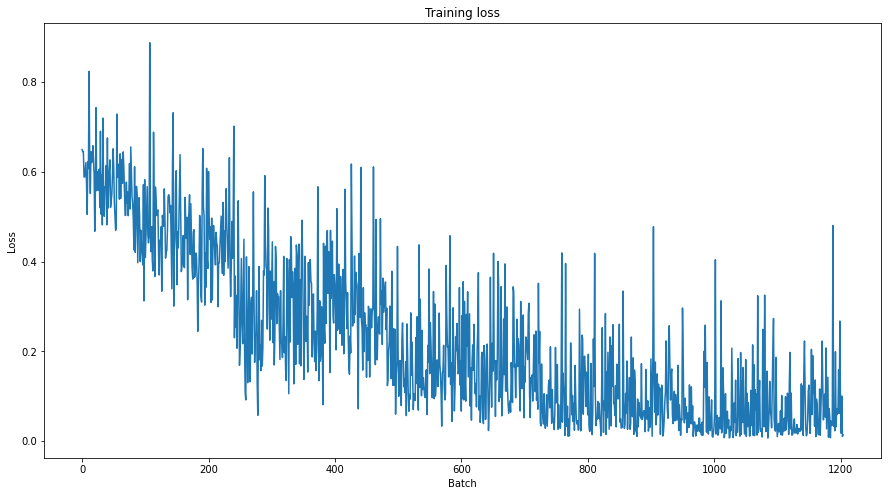

In [26]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [28]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [29]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [30]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [31]:
# scores of individual batches
matthews_set

[0.049286405809014416,
 0.014456362470655182,
 0.4857959309463206,
 0.17338428937260214,
 0.5945883900105632,
 0.7410010097502685,
 0.4472135954999579,
 0.0,
 0.8320502943378436,
 0.6952687917708212,
 0.9229582069908973,
 0.7453559924999299,
 0.8150678894028793,
 0.7948717948717948,
 0.38461538461538464,
 0.5716350506349809,
 0.0]

In [32]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5604659384820143